# Cause-of-Death Mortality Modeling with multitask Neural Network
In this file, we will test different architectures to model cause-of-death mortality data

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Embedding, BatchNormalization, Dropout, Concatenate
from keras.utils import plot_model

## Import dataset

In [4]:
os.chdir("..")
MYwd= os.getcwd()
file_path = MYwd+r"\Data\cause_specific_Short_Reconstructed\USA_m_short_idr.csv"          # short list
#file_path = MYwd+r"\Data\cause_specific_Interm_Reconstructed\USA_m_interm_idr.csv"       #intermediate list
#file_path = MYwd+r"\Data\cause_specific_Long_Reconstructed\USA_m_long_idr.csv"       #long list

data = pd.read_csv(file_path)

# Divide by 1,000,000 
exclude_cols = ['country', 'year', 'sex', 'list', 'agf', 'cause']
data.loc[:, ~data.columns.isin(exclude_cols)] = data.loc[:, ~data.columns.isin(exclude_cols)] / 1000000

# only keep the lines for both sexes: 
subset = data[data['sex'] == 3]
subset = subset.drop(columns=['sex', 'list', 'agf', 'total', 'm85p', 'm90p', 'm95p'])

df = subset.melt(id_vars=['country', 'year', 'cause'], var_name='age', value_name='m')
df['age'] = df['age'].str.extract('(\d+)').astype(int)                           # Convert 'age' from 'mX' format to just 'X'
df['log_m'] = np.log(df['m'].replace(0,1e-8))                                    # add log mortality, avoid taking log(0)

# Prepare data to feed into neural network: 
df['cause'] = df['cause'].astype('category').cat.codes      # convert to categorical variable

df['year'] = df['year'].astype('float')    # neural nets prefer floats over ints
df['age'] = df['age'].astype('float')

# Division in training and test set

In [6]:
 # Set up the training set
train = df[(df['year'].between(1979, 2011))]
train = train.copy() 

test_set = df[(df['year'].between(2012, 2021))]
test_set = test_set.copy()

## Neural Network Model

In [10]:
from keras.callbacks import Callback

class PrintSomeEpochs(Callback):
    def __init__(self, print_every=5):  # Customize frequency
        self.print_every = print_every

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.print_every == 0:  # Print every N epochs
            print(f"Epoch {epoch+1}: loss={logs['loss']:.4f}, val_loss={logs['val_loss']:.4f}")

# Attach callback to training
print_callback = PrintSomeEpochs(print_every=10)  # Print every 10 epochs

In [11]:
    unique_combos = train[['year', 'age']].drop_duplicates()
    # Reshape inputs and set to numpy arrays
    year = np.array(unique_combos['year'].values.reshape(-1,1))
    age = np.array(unique_combos['age'].values.reshape(-1,1))
    
    year_mean, year_std = year.mean(), year.std()
    age_mean, age_std = age.mean(), age.std()
    

In [12]:
def prepare_input_data(data):
    # Extract unique combos of 'year' and 'age'
    unique_combos = data[['year', 'age']].drop_duplicates()
    
    # Reshape inputs and set to numpy arrays
    year = np.array(unique_combos['year'].values.reshape(-1,1))
    age = np.array(unique_combos['age'].values.reshape(-1,1))
    
    year_norm = (year - year_mean) / year_std
    age_norm = (age - age_mean) / age_std
    
    X = [year_norm, age_norm]
    
    ncauses = len(data['cause'].drop_duplicates())
    rows = len(data['log_m'].values) // ncauses          
    Y = data['log_m'].values.reshape(rows, ncauses)      

    
    return X, Y

In [71]:
ncauses

207

In [13]:
#############################
### Set up neural network ###
#############################


def build_model_inputx2(units=[500, 256], 
                                       head_units=[32], 
                                       ncauses=17, 
                                       activation='relu', 
                                       drop=0.2, 
                                       learning_rate=0.001):
    # Input layers
    year = Input(shape=(1,), name='year')
    age = Input(shape=(1,), name='age')
    features = Concatenate()([year, age])
    
    # Shared fully connected base
    x = features
    for u in units:
        x = Dense(u, activation=activation)(x)
        x = BatchNormalization()(x)
        x = Dropout(drop)(x)
    
    # Output from base model: one value per cause (vector)
    base_output = Dense(ncauses, activation='linear', name='base_output')(x)
    
    # Now: one mini-network per element of that output vector
    outputs = []
    
    for i in range(ncauses):
        # Slice the i-th element from the base output
        single_cause_input = Lambda(lambda z: z[:, i:i+1])(base_output)
        
        # Concatenate with original inputs (year and age)
        enriched_input = Concatenate()([single_cause_input, features])  # features = [year, age]
        
        xi = enriched_input
        for hu in head_units:
            xi = Dense(hu, activation=activation)(xi)
            xi = BatchNormalization()(xi)
            xi = Dropout(drop)(xi)
        
        cause_output = Dense(1, activation='linear', name=f'cause_{i}_output')(xi)
        outputs.append(cause_output)

    # Final model outputs a concatenation of all cause-specific outputs
    output_layer = Concatenate(name='final_output')(outputs)
    
    model = Model(inputs=[year, age], outputs=output_layer)
    
    Adam_optimizer = tf.keras.optimizers.Adam(learning_rate)
    model.compile(optimizer=Adam_optimizer, loss='mse', metrics=['mae'])
    
    return model

In [14]:
#############################
### Set up neural network ###
#############################


def build_model(units=np.array([256, 256,128]), ncauses=17, activation = 'relu', drop=0.2, learning_rate=0.001):
    # Define the input layers
    year = Input(shape=(1,), dtype='float32', name='year')
    age = Input(shape=(1,), dtype='float32', name='age')
    
    # Concatenate the defined features
    features = Concatenate()([year, age])
    
    x = Dense(units=units[0], activation=activation)(features)
    x = BatchNormalization()(x)
    x = Dropout(drop)(x)
    
    # Define the hidden layers
    for i in range(1, len(units)): 
        x = Dense(units=units[i], activation=activation)(x)
        x = BatchNormalization()(x)
        x = Dropout(drop)(x)
    
    # Define the output layer
    target = Dense(units=ncauses, activation='linear')(x)      
    
    model = Model(inputs=[year, age], outputs=target)
    
    Adam_optimizer = tf.keras.optimizers.Adam(learning_rate)
    model.compile(optimizer=Adam_optimizer, loss='mse', metrics=['mae'])
    
    return model

In [15]:
# Build two stage NN

from keras.layers import Lambda

def build_two_stage_model(units=np.array([500, 256, 128]), 
                          head_units=[32], 
                          ncauses=17, 
                          activation='relu', 
                          drop=0.2, 
                          learning_rate=0.001):
    
    # Inputs
    year = Input(shape=(1,), dtype='float32', name='year')
    age = Input(shape=(1,), dtype='float32', name='age')
    features = Concatenate()([year, age])
    
    # Shared Base Network
    x = features
    for i in range(len(units)):
        x = Dense(units[i], activation=activation)(x)
        x = BatchNormalization()(x)
        x = Dropout(drop)(x)
    
    # Separate heads for each cause
    outputs = []
    for i in range(ncauses):
        xi = x
        print(xi)
        for hu in head_units:
            xi = Dense(hu, activation=activation)(xi)
            xi = BatchNormalization()(xi)
            xi = Dropout(drop)(xi)
        # Output per cause: scalar
        cause_output = Dense(1, activation='linear', name=f'cause_{i}')(xi)
        outputs.append(cause_output)
    
    # Final model outputs a concatenation of all cause-specific outputs
    output_layer = Concatenate(name='final_output')(outputs)
    
    model = Model(inputs=[year, age], outputs=output_layer)
    
    Adam_optimizer = tf.keras.optimizers.Adam(learning_rate)
    model.compile(optimizer=Adam_optimizer, loss='mse', metrics=['mae'])
    
    return model


In [16]:
from keras.layers import Lambda, Reshape

def build_two_stage_model_split_output(units=[500, 256,128,128], 
                                       head_units=[32], 
                                       ncauses=17, 
                                       activation='relu', 
                                       drop=0.2, 
                                       learning_rate=0.001):
    
    # Input layers
    year = Input(shape=(1,), name='year')
    age = Input(shape=(1,), name='age')
    features = Concatenate()([year, age])
    
    # Shared fully connected base
    x = features
    for u in units:
        x = Dense(u, activation=activation)(x)
        x = BatchNormalization()(x)
        x = Dropout(drop)(x)
    
    # Output from base model: one value per cause (vector)
    base_output = Dense(ncauses, activation='linear', name='base_output')(x)
    
    # Now: one mini-network per element of that output vector
    outputs = []
    for i in range(ncauses):
        # Slice the i-th element from the base output
        single_cause_input = Lambda(lambda z: z[:, i:i+1])(base_output)
        xi = single_cause_input
        for hu in head_units:
            xi = Dense(hu, activation=activation)(xi)
            xi = BatchNormalization()(xi)
            xi = Dropout(drop)(xi)
        cause_output = Dense(1, activation='linear', name=f'cause_{i}_output')(xi)
        outputs.append(cause_output)
    
    # Concatenate final outputs back into a vector
    final_output = Concatenate(name='final_output')(outputs)
    
    model = Model(inputs=[year, age], outputs=final_output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='mse', metrics=['mae'])
    
    return model


### Train the Neural Network

In [18]:
ncauses = len(train['cause'].drop_duplicates())
X_train, Y_train = prepare_input_data(train)
epochs = 300
batch = 64

In [19]:
# training the model
#model = build_model()
# optimal architecture: 
model4 = build_model(units=np.array([256, 128, 128]), ncauses=ncauses)

history4 = model4.fit(x=X_train, y=Y_train, batch_size=batch, epochs=epochs, verbose=1, validation_split=0.1)
#history = model.fit(x=X_train, y=Y_train, batch_size=batch, epochs=epochs, verbose=1)


Epoch 1/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 202.6082 - mae: 13.7474 - val_loss: 148.3577 - val_mae: 11.1987
Epoch 2/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 199.1246 - mae: 13.6794 - val_loss: 149.1066 - val_mae: 11.2522
Epoch 3/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 197.3081 - mae: 13.6702 - val_loss: 150.6593 - val_mae: 11.3478
Epoch 4/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 195.1668 - mae: 13.6206 - val_loss: 151.9505 - val_mae: 11.4260
Epoch 5/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 192.7942 - mae: 13.5385 - val_loss: 152.3732 - val_mae: 11.4544
Epoch 6/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 190.6552 - mae: 13.4629 - val_loss: 151.6076 - val_mae: 11.4206
Epoch 7/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 185.2634 - mae: 13.2514 - val_loss: 148.5582 - val_mae: 11.2811
Epoch 8/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 182.7530 - mae: 13.1592 - val_loss: 144.4298 - val_mae: 11.0954
Epoch 9/300
11/

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ year (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2)         │          0 │ year[0][0],       │
│ (Concatenate)       │                   │            │ age[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │        768 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     16,512 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 207)       │     26,703 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 234,735 (916.94 KB)

 Trainable params: 77,903 (304.31 KB)

 Non-trainable params: 1,024 (4.00 KB)

 Optimizer params: 155,808 (608.63 KB)

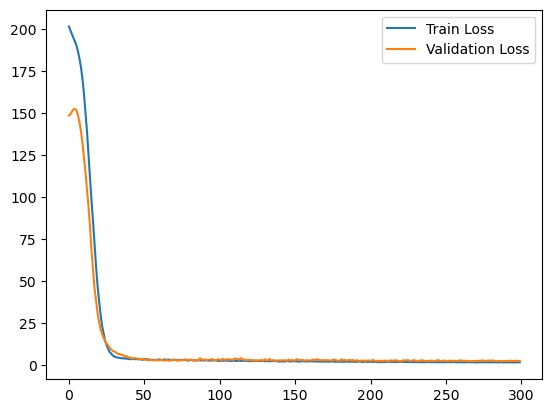

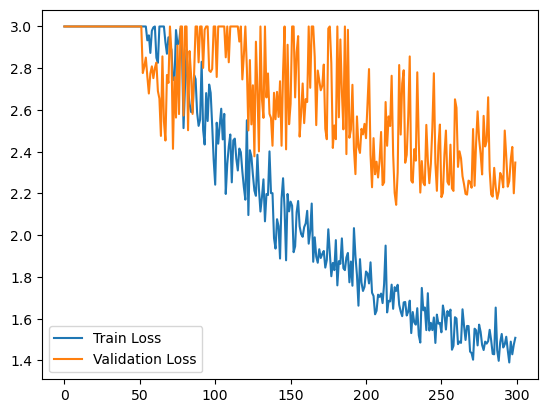

In [20]:

model4.summary()

plt.plot(history4.history['loss'], label='Train Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()
capped_val_loss4 = [x if x <= 3 else 3 for x in history4.history['val_loss']]
capped_loss4 = [x if x <= 3 else 3 for x in history4.history['loss']]
plt.plot(capped_loss4, label='Train Loss')
plt.plot(capped_val_loss4, label='Validation Loss')
plt.legend()
plt.show()

In [21]:
# training the model
#model = build_model()
# optimal architecture: 
model1 = build_model_inputx2(units=np.array([ 256, 128, 128]), ncauses=ncauses)

history1 = model1.fit(x=X_train, y=Y_train, batch_size=batch, epochs=epochs, verbose=1, validation_split=0.1)
#history = model.fit(x=X_train, y=Y_train, batch_size=batch, epochs=epochs, verbose=1)



Epoch 1/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 297s 1s/step - loss: 201.8054 - mae: 13.6546 - val_loss: 148.8709 - val_mae: 11.2057
Epoch 2/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 200.3828 - mae: 13.6534 - val_loss: 147.9179 - val_mae: 11.1813
Epoch 3/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 194.7244 - mae: 13.4779 - val_loss: 146.9693 - val_mae: 11.1569
Epoch 4/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 192.7686 - mae: 13.4449 - val_loss: 146.0342 - val_mae: 11.1336
Epoch 5/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 189.6899 - mae: 13.3574 - val_loss: 144.9742 - val_mae: 11.1039
Epoch 6/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 190.2403 - mae: 13.4097 - val_loss: 143.9223 - val_mae: 11.0759
Epoch 7/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 183.3543 - mae: 13.1530 - val_loss: 142.6980 - val_mae: 11.0395
Epoch 8/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 180.0780 - mae: 13.0389 - val_loss: 141.4193 - val_mae: 11.0019
Epoch 9

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ year (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 2)         │          0 │ year[0][0],       │
│ (Concatenate)       │                   │            │ age[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │        768 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     32,896 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_5[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │     16,512 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_6[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ base_output (Dense) │ (None, 207)       │     26,703 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1)         │          0 │ base_output[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 1)         │          0 │ base_output[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 1)         │          0 │ base_output[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 1)         │          0 │ base_output[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 1)         │          0 │ base_output[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_5 (Lambda)   │ (None, 1)         │          0 │ base_output[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_6 (Lambda)   │ (None, 1)         │          0 │ base_output[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_7 (Lambda)   │ (None, 1)         │          0 │ base_output[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_8 (Lambda)   │ (None, 1)         │          0 │ base_output[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_9 (Lambda)   │ (None, 1)         │          0 │ base_output[0][0

 Total params: 387,708 (1.48 MB)

 Trainable params: 124,478 (486.24 KB)

 Non-trainable params: 14,272 (55.75 KB)

 Optimizer params: 248,958 (972.50 KB)

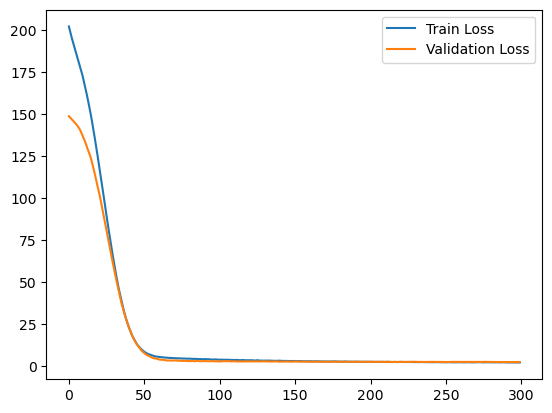

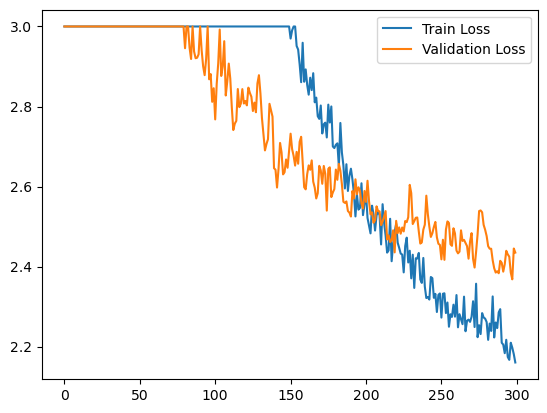

In [22]:

model1.summary()

plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()
capped_val_loss1 = [x if x <= 3 else 3 for x in history1.history['val_loss']]
capped_loss1 = [x if x <= 3 else 3 for x in history1.history['loss']]
plt.plot(capped_loss1, label='Train Loss')
plt.plot(capped_val_loss1, label='Validation Loss')
plt.legend()
plt.show()

In [23]:
model2 = build_two_stage_model(units=[256, 128, 128], head_units=[64], ncauses=ncauses)

history2 = model2.fit(x=X_train, y=Y_train, batch_size=batch, epochs=epochs,
                    validation_split=0.1, callbacks=[print_callback])


<KerasTensor shape=(None, 128), dtype=float32, sparse=False, name=keras_tensor_1688>
<KerasTensor shape=(None, 128), dtype=float32, sparse=False, name=keras_tensor_1688>
<KerasTensor shape=(None, 128), dtype=float32, sparse=False, name=keras_tensor_1688>
<KerasTensor shape=(None, 128), dtype=float32, sparse=False, name=keras_tensor_1688>
<KerasTensor shape=(None, 128), dtype=float32, sparse=False, name=keras_tensor_1688>
<KerasTensor shape=(None, 128), dtype=float32, sparse=False, name=keras_tensor_1688>
<KerasTensor shape=(None, 128), dtype=float32, sparse=False, name=keras_tensor_1688>
<KerasTensor shape=(None, 128), dtype=float32, sparse=False, name=keras_tensor_1688>
<KerasTensor shape=(None, 128), dtype=float32, sparse=False, name=keras_tensor_1688>
<KerasTensor shape=(None, 128), dtype=float32, sparse=False, name=keras_tensor_1688>
<KerasTensor shape=(None, 128), dtype=float32, sparse=False, name=keras_tensor_1688>
<KerasTensor shape=(None, 128), dtype=float32, sparse=False, name

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ year (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_209     │ (None, 2)         │          0 │ year[0][0],       │
│ (Concatenate)       │                   │            │ age[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_214 (Dense)   │ (None, 256)       │        768 │ concatenate_209[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_214[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_213         │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_215 (Dense)   │ (None, 128)       │     32,896 │ dropout_213[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_215[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_214         │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_216 (Dense)   │ (None, 128)       │     16,512 │ dropout_214[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_216[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_215         │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_217 (Dense)   │ (None, 64)        │      8,256 │ dropout_215[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_218 (Dense)   │ (None, 64)        │      8,256 │ dropout_215[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_219 (Dense)   │ (None, 64)        │      8,256 │ dropout_215[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_220 (Dense)   │ (None, 64)        │      8,256 │ dropout_215[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_221 (Dense)   │ (None, 64)        │      8,256 │ dropout_215[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_222 (Dense)   │ (None, 64)        │      8,256 │ dropout_215[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_223 (Dense)   │ (None, 64)        │      8,256 │ dropout_215[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_224 (Dense)   │ (None, 64)        │      8,256 │ dropout_215[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_225 (Dense)   │ (None, 64)        │      8,256 │ dropout_215[0][0] │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 5,427,951 (20.71 MB)

 Trainable params: 1,800,143 (6.87 MB)

 Non-trainable params: 27,520 (107.50 KB)

 Optimizer params: 3,600,288 (13.73 MB)

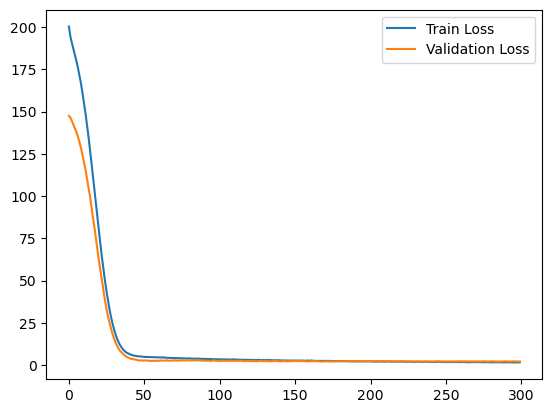

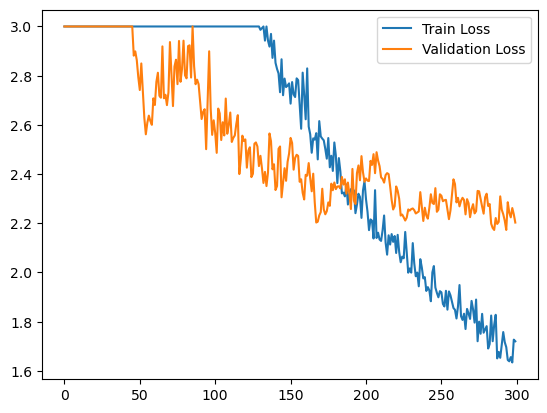

In [24]:

model2.summary()

plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()
capped_val_loss2 = [x if x <= 3 else 3 for x in history2.history['val_loss']]
capped_loss2 = [x if x <= 3 else 3 for x in history2.history['loss']]
plt.plot(capped_loss2, label='Train Loss')
plt.plot(capped_val_loss2, label='Validation Loss')
plt.legend()
plt.show()

In [25]:
model3 = build_two_stage_model_split_output(units=[ 256, 128, 128], head_units=[64], ncauses=ncauses)

history3 = model3.fit(x=X_train, y=Y_train, batch_size=batch, epochs=epochs, 
                    validation_split=0.1, callbacks=[print_callback])


Epoch 1/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1732s 2s/step - loss: 202.4116 - mae: 13.6957 - val_loss: 145.7130 - val_mae: 11.0701
Epoch 2/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - loss: 196.4855 - mae: 13.5316 - val_loss: 143.4444 - val_mae: 10.9747
Epoch 3/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - loss: 192.6140 - mae: 13.4726 - val_loss: 141.2403 - val_mae: 10.8843
Epoch 4/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - loss: 189.4230 - mae: 13.3961 - val_loss: 138.8947 - val_mae: 10.7871
Epoch 5/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 183.2288 - mae: 13.1717 - val_loss: 136.3717 - val_mae: 10.6818
Epoch 6/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - loss: 179.7713 - mae: 13.0496 - val_loss: 133.4657 - val_mae: 10.5555
Epoch 7/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - loss: 176.9292 - mae: 12.9521 - val_loss: 130.1944 - val_mae: 10.4097
Epoch 8/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - loss: 170.8166 - mae: 12.7123 - val_loss: 126.6488 - val_mae: 10.2513


In [26]:
# save the model
#model.save("NNmodelCauseOfDeath.keras")
#loaded_model = tf.keras.models.load_model("NNmodelCauseOfDeath.keras")

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ year (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_210     │ (None, 2)         │          0 │ year[0][0],       │
│ (Concatenate)       │                   │            │ age[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_424 (Dense)   │ (None, 256)       │        768 │ concatenate_210[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_424[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_423         │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_425 (Dense)   │ (None, 128)       │     32,896 │ dropout_423[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_425[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_424         │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_426 (Dense)   │ (None, 128)       │     16,512 │ dropout_424[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_426[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_425         │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ base_output (Dense) │ (None, 207)       │     26,703 │ dropout_425[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_207 (Lambda) │ (None, 1)         │          0 │ base_output[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_208 (Lambda) │ (None, 1)         │          0 │ base_output[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_209 (Lambda) │ (None, 1)         │          0 │ base_output[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_210 (Lambda) │ (None, 1)         │          0 │ base_output[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_211 (Lambda) │ (None, 1)         │          0 │ base_output[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_212 (Lambda) │ (None, 1)         │          0 │ base_output[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_213 (Lambda) │ (None, 1)         │          0 │ base_output[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_214 (Lambda) │ (None, 1)         │          0 │ base_output[0][0] │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 460,572 (1.76 MB)

 Trainable params: 144,350 (563.87 KB)

 Non-trainable params: 27,520 (107.50 KB)

 Optimizer params: 288,702 (1.10 MB)

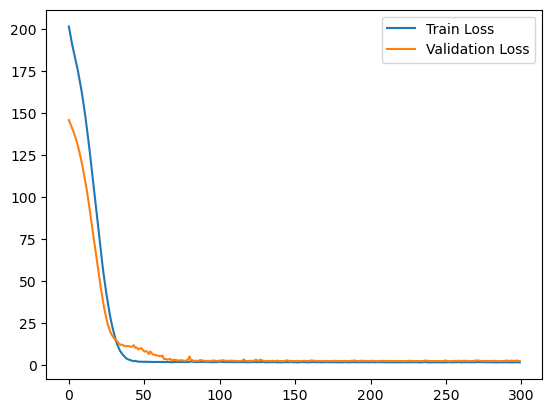

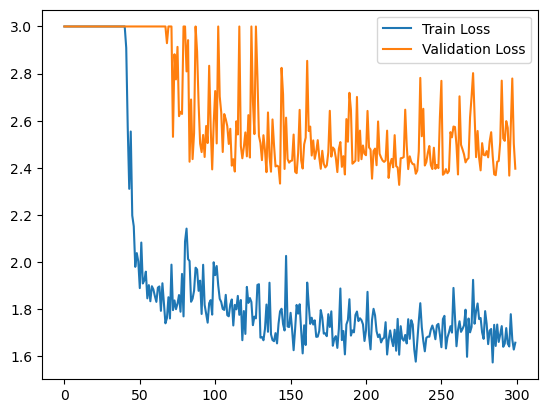

In [27]:

model3.summary()

plt.plot(history3.history['loss'], label='Train Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()
capped_val_loss3 = [x if x <= 3 else 3 for x in history3.history['val_loss']]
capped_loss3 = [x if x <= 3 else 3 for x in history3.history['loss']]
plt.plot(capped_loss3, label='Train Loss')
plt.plot(capped_val_loss3, label='Validation Loss')
plt.legend()
plt.show()

### Test the Network on unseen data

In [29]:
models =  [model1, model2, model3, model4]

In [30]:
X_test, Y_test = prepare_input_data(test_set)
for i in range(len(models)):
    model = models[i]
    score = model.evaluate(X_test, Y_test, verbose=0)
    print(model.metrics_names)
    print(score)

    # score on training set:
    score_train = model.evaluate(X_train, Y_train, verbose=0)
    print(score_train)


    # predictions on the test set: 
    predic = model.predict(X_test)
    test_set['prediction'+str(i)] = predic.reshape(-1,1)
    
    causes = test_set['cause'].drop_duplicates()
    overall_mse = mean_squared_error(test_set['log_m'], test_set['prediction'+str(i)])

    print(f'Overall mse: {overall_mse}')


['loss', 'compile_metrics']
[1.2900323867797852, 0.6518058180809021]
[0.6015381217002869, 0.4178038537502289]
7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step
Overall mse: 1.2900324045241702
['loss', 'compile_metrics']
[1.0702863931655884, 0.526506781578064]
[0.5342753529548645, 0.37337449193000793]
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step
Overall mse: 1.0702863271433312
['loss', 'compile_metrics']
[1.3422956466674805, 0.6800547242164612]
[0.8318409323692322, 0.5185860395431519]
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step
Overall mse: 1.3422956354746214
['loss', 'compile_metrics']
[1.116438865661621, 0.591759204864502]
[0.6764882206916809, 0.4574679136276245]
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Overall mse: 1.1164388212089167


C:\Users\m8eld\AppData\Local\Temp\ipykernel_29392\4277069564.py:11: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for ax, (_, subset) in zip(g.axes.flat, test_set.groupby(['cause'])):


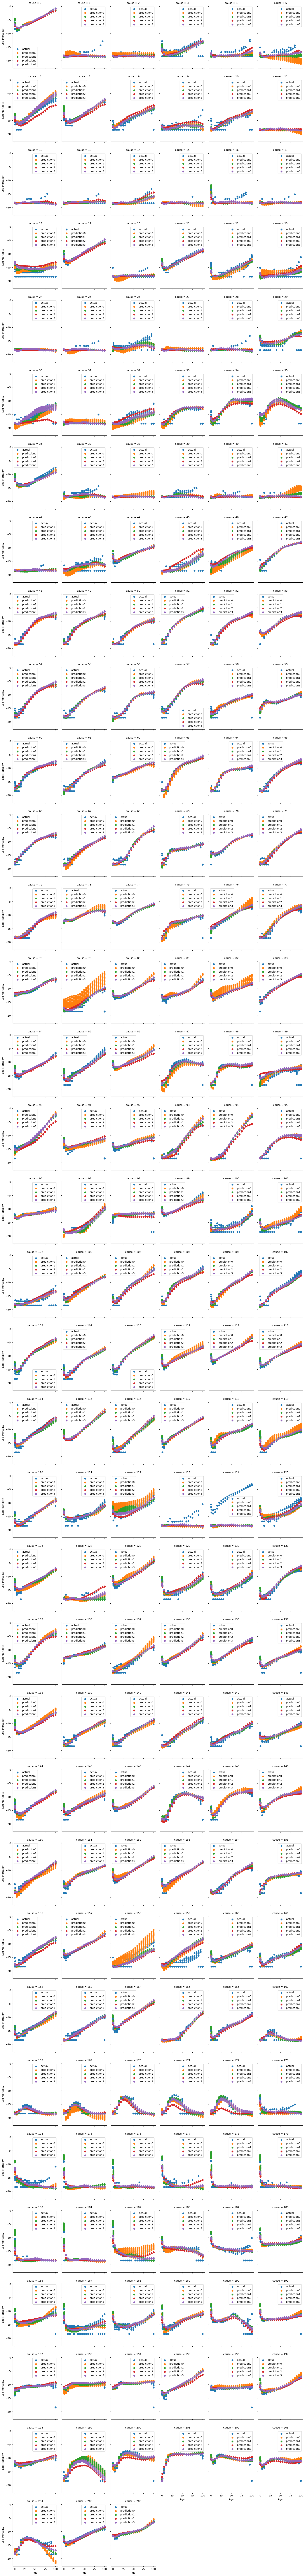

In [31]:
# goodness of fit on plot
g = sns.FacetGrid(test_set, col='cause', palette='mako',
                  margin_titles=True, height=4, aspect=0.7, col_wrap=6)

g.map(sns.scatterplot, 'age', 'log_m', s=20)

# Adjust the title, legend, and axis formatting
g.set_axis_labels("Age", "Log Mortality")


for ax, (_, subset) in zip(g.axes.flat, test_set.groupby(['cause'])):
    scatter = ax.scatter(subset['age'], subset['log_m'], label='actual')
    ax.scatter(subset['age'], subset['prediction0'], label='prediction0')
    ax.scatter(subset['age'], subset['prediction1'], label='prediction1')
    ax.scatter(subset['age'], subset['prediction2'], label='prediction2')
    ax.scatter(subset['age'], subset['prediction3'], label='prediction3')
    ax.legend()

In [32]:

causes = test_set['cause'].drop_duplicates()
for i in range( len(models)):
    overall_mse = mean_squared_error(test_set['log_m'], test_set['prediction'+str(i)])

    print(f'Overall mse: {overall_mse}')

    mse_df = pd.DataFrame(columns=['Cause', 'mse_nn'])
    index = 0

    for cause in causes:

        subset = test_set[test_set['cause'] == cause]
        mse = mean_squared_error(subset['log_m'], subset['prediction'+str(i)])

        mse_df.loc[index] = [cause, mse]
        index += 1

    print(mse_df)

Overall mse: 1.2900324045241702
     Cause    mse_nn
0      0.0  0.225355
1      1.0  0.672901
2      2.0  0.497914
3      3.0  3.180557
4      4.0  0.905457
..     ...       ...
202  202.0  0.720588
203  203.0  1.346157
204  204.0  2.254388
205  205.0  0.270376
206  206.0  0.153114

[207 rows x 2 columns]
Overall mse: 1.0702863271433312
     Cause    mse_nn
0      0.0  0.260014
1      1.0  0.356064
2      2.0  0.119485
3      3.0  2.660211
4      4.0  0.772918
..     ...       ...
202  202.0  0.626091
203  203.0  0.933713
204  204.0  0.743436
205  205.0  0.249014
206  206.0  0.066183

[207 rows x 2 columns]
Overall mse: 1.3422956354746214
     Cause    mse_nn
0      0.0  0.362256
1      1.0  0.293007
2      2.0  0.058715
3      3.0  3.094692
4      4.0  1.656524
..     ...       ...
202  202.0  1.291674
203  203.0  1.151373
204  204.0  2.047570
205  205.0  0.209586
206  206.0  0.278147

[207 rows x 2 columns]
Overall mse: 1.1164388212089167
     Cause    mse_nn
0      0.0  0.331055
1 

In [33]:
#mse_df.to_excel("mse_NN.xlsx", index=False)

Train multiple times

In [35]:

results = {}
# Loop through each model configuration
for idx, model in enumerate(models):
    model_name = f"Model_{idx+1}"
    mse_list = []
    for run in range(30):
        model.fit(X_train, Y_train, epochs=10, verbose=0)  # adjust as needed
        score = model.evaluate(X_test, Y_test, verbose=0)
        predic = model.predict(X_test)
        
        predic_flat = predic.reshape(-1)
        overall_mse = mean_squared_error(test_set['log_m'], predic_flat)
        mse_list.append(overall_mse)

    results[model_name] = mse_list

# Convert results to DataFrame for seaborn
results_df = pd.DataFrame({
    "Model": [model for model in results for _ in results[model]],
    "MSE": [mse for mses in results.values() for mse in mses]
})



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
7/7 ━━━━━━━━

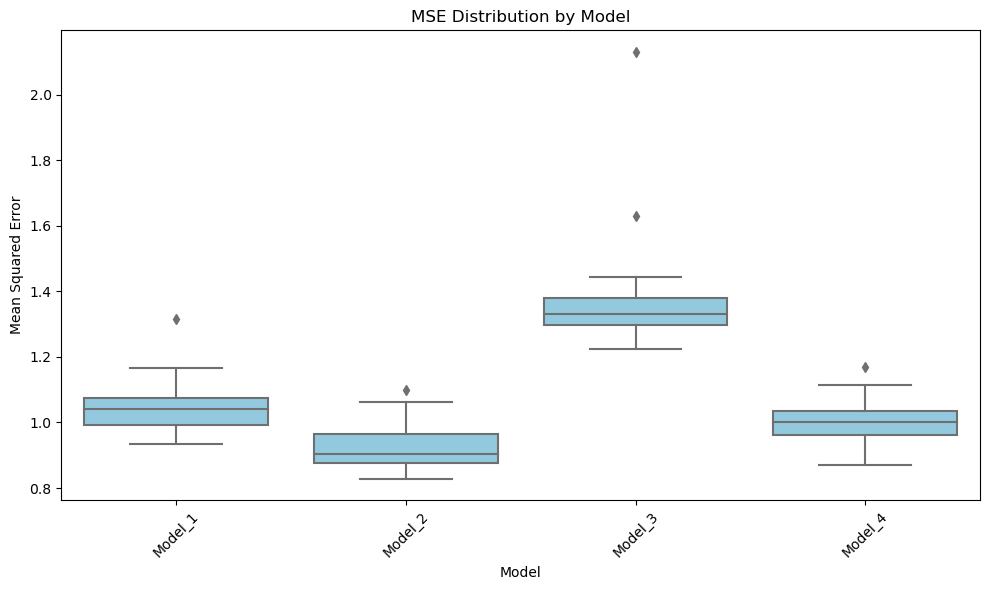

In [36]:
# Plot boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x="Model", y="MSE", data=results_df, color='skyblue')
plt.title("MSE Distribution by Model")
plt.ylabel("Mean Squared Error")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('modelcomparison.jpg')
plt.show()

In [69]:
# Convert results to DataFrame for seaborn
#results_df = pd.DataFrame({    "Model": [model for model in results for _ in results[model]],    "MSE": [mse for mses in results.values() for mse in mses]})
#print(results_df[results_df['Model']=='Model_2'])
print(min(results_df[results_df['Model']=='Model_2']['MSE']))
print(min(results_df[results_df['Model']=='Model_4']['MSE']))


0.8285976666749821
0.8707409667268616
